<a href="https://colab.research.google.com/github/mlvlab/vision-tutorial/blob/master/5_Object_Detection_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab Session #5: Object Detection**


by Sihyeon Kim (mlv lab @ Korea University) on October 2019

for SKC Lecture, Fall 2019 (Prof. Hyunwoo J. Kim)


---
**Contents**
1. Object Detection Tutorial: Inference with a pretrained model
2. Finetuning a pretrained model for certain purpose


**Reference**

* [Object Detection Tutorial](https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)


* [Object Detection Finetuning](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#)

---




# 2. Finetuning a pretrained model for certain purpose



*   Finetuning for your particular dataset from a pretrained model
*   Modifying the model to change a backbone network



In [0]:
import os
import numpy as np
import torch
import torchvision
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms as T

In [0]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

In [0]:
%%shell

# download the Penn-Fudan dataset

wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

In [0]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

In [0]:
import torch.utils.data

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F5586E53668>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1])})

In [0]:
# pretrained model을 가져와서 finetuning해볼 것임
# 첫번째 방법: 미리 학습된 모델에서 시작해서 마지막 레이어 수준만 미세 조정하는 것
# 우리는 사람클래스해서 딱 2개만 필요하니까 마지막 레이어를 바꾸는 거임
# Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_model(num_classes):
    # COCO 에서 미리 학습된 인스턴스 분할 모델을 읽어옵니다
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # 분류를 위한 입력 특징 차원을 얻습니다
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 미리 학습된 헤더를 새로운 것으로 바꿉니다
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [12]:
# let's train it for 10 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:03:18  lr: 0.000090  loss: 1.2332 (1.2332)  loss_classifier: 1.0216 (1.0216)  loss_box_reg: 0.2010 (0.2010)  loss_objectness: 0.0030 (0.0030)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 3.3019  data: 0.2742  max mem: 3078
Epoch: [0]  [10/60]  eta: 0:01:27  lr: 0.000936  loss: 0.9685 (0.9112)  loss_classifier: 0.7130 (0.6360)  loss_box_reg: 0.2186 (0.2461)  loss_objectness: 0.0145 (0.0181)  loss_rpn_box_reg: 0.0076 (0.0111)  time: 1.7402  data: 0.0319  max mem: 3316
Epoch: [0]  [20/60]  eta: 0:01:07  lr: 0.001783  loss: 0.5062 (0.6999)  loss_classifier: 0.2784 (0.4423)  loss_box_reg: 0.2158 (0.2297)  loss_objectness: 0.0142 (0.0153)  loss_rpn_box_reg: 0.0110 (0.0125)  time: 1.5958  data: 0.0073  max mem: 3316
Epoch: [0]  [30/60]  eta: 0:00:48  lr: 0.002629  loss: 0.3435 (0.5542)  loss_classifier: 0.1024 (0.3216)  loss_box_reg: 0.1933 (0.2065)  loss_objectness: 0.0099 (0.0142)  loss_rpn_box_reg: 0.0106 (0.0119)  time: 1.5476  data: 0.0070  max mem: 3316
Epoch: [

In [0]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [17]:
print(prediction)

[{'boxes': tensor([[ 61.9035,  39.1261, 195.6433, 322.0496],
        [276.4688,  24.3870, 291.0222,  74.8683]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1392], device='cuda:0')}]


In [0]:
# convert tensor image to ndarray image
# permute for dimension convert (C,H,W) -> (H,W,C)

img2 = img.mul(255).permute(1, 2, 0).byte().numpy()

In [0]:
boxes = prediction[0]['boxes'].cpu().detach().numpy()
boxes = boxes.astype(int)
labels = prediction[0]['labels'].tolist()
scores = prediction[0]['scores'].tolist()

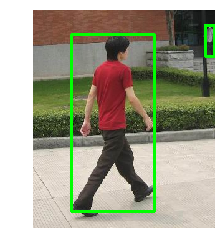

In [31]:
for i in range(len(labels)):
  x1 = boxes[i,0]
  y1 = boxes[i,1]
  x2 = boxes[i,2]
  y2 = boxes[i,3]
  cv2.rectangle(img2, (x1,y1), (x2,y2),color=(0, 255, 0), thickness=3) # Draw Rectangle with the coordinates
plt.imshow(img2)
plt.axis('off')
plt.show()

Changing a backbone network?

In [0]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN needs to know the number of output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial location
# with 5 different sizes and 3 different aspect ratios. 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model2 = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)